# Argiro Zisi 1115202000054
## AI2 Homework 2 : Pytorch and NN Models

### In the following notebook, I divide the process of model training and results presentation as follows: Step 1) Data preprocessing, Step 2) Embeddings, Step 3) Dataset preparation, Step 4) Model, Step 5) Loss function & optimizer, Step 6) Training, Step 7) Evaluation. In each step, I present in detail all the experiments I tried, the hyperparameter tuning, and their results. Every stage includes: (1) the initial implementation, (2) systematic variations tested (e.g., alternative approaches, hyperparameter ranges), (3) quantitative/qualitative outcomes, and (4) the final chosen configuration with justification.

## Step 1) Preprocessing data
In this step we process the data. In detail I have tried: removal of stopwords, lemmatization vs stemming, removal of punctuation, removal/replacement of urls, mentions, emojis, spelling corrections, lowercasing, tokenization, removal of empty tweets, balanced/imbalanced classes, length of tweets, wordcloud, processing of hashtags.

In [455]:
# Installation of all necessary libraries.
!pip install nltk
!pip install spacy
!pip install emoji
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.7 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [456]:
# Importing libraries
import re
import string
import emoji
import nltk
import spacy
import pandas as pd

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from tqdm.notebook import tqdm
tqdm.pandas()  

# Downloading nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Stopwords
stop_words = set(stopwords.words('english'))

# Stemmers
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer(language='english')

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# SpaCy (without parser/NER for better performance)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [457]:
# Load the datasets
train_df = pd.read_csv(r'/kaggle/input/proj-dataset/train_dataset.csv')
val_df = pd.read_csv(r'/kaggle/input/proj-dataset/val_dataset.csv')
test_df = pd.read_csv(r'/kaggle/input/proj-dataset/test_dataset.csv')
print(test_df.shape)

(21199, 2)


In [458]:
#lowercasing in training, validation and test set
train_df['Text'] = train_df['Text'].str.lower()
val_df['Text'] = val_df['Text'].str.lower()
test_df['Text'] = test_df['Text'].str.lower()

# Check for tweets that still contain uppercase letters.
uppercase_in_train = train_df['Text'].str.contains(r'[A-Z]').sum()
uppercase_in_val = val_df['Text'].str.contains(r'[A-Z]').sum()
uppercase_in_test = test_df['Text'].str.contains(r'[A-Z]').sum()

print(f"Uppercase in train: {uppercase_in_train}")
print(f"Uppercase in val: {uppercase_in_val}")
print(f"Uppercase in test: {uppercase_in_test}")


Uppercase in train: 0
Uppercase in val: 0
Uppercase in test: 0


In [459]:
# Dictionary for correcting misspelled words
correction_dict = {
    "ur": "you are", "u": "you", "heartsy": "heart", "What's": "what is", "we've": "we have", 
    "i'm": "i am", "gta": "got to", "schbag": "shoulder bag", "won't": "will not", 
    "it's": "it is", "2night": "tonight", "don't": "do not", "waitin": "waiting",
    "depro": "depressed", "omg": "oh my god", "btw": "by the way", "tweeps": "twitter", 
    "tommorow": "tommorrow", "thru": "through", "yum": "yummy", "can't": "cannot", 
    "you're": "you are", "ap": "autograph page", "thingy": "thing", "pic": "picture",
    "there's": "there is", "1st": "first", "limo": "limosine", "yeh": "yes", "sumtimes": "sometimes", 
}
# Dictionary for correcting slang words
slang_dict = {
    "2day": "today","2moro": "tomorrow","2nite": "tonight","4ever": "forever","b4": "before","bday": "birthday","bf": "boyfriend","bff": "best friend forever",
    "brb": "be right back","btw": "by the way","cya": "see you","dm": "direct message","fb": "facebook","g2g": "got to go","gg": "good game",
    "gr8": "great","h8": "hate","idk": "i don't know","imo": "in my opinion","irl": "in real life","jk": "just kidding","l8r": "later",
    "lol": "laugh out loud","msg": "message","nvm": "never mind","omg": "oh my god","plz": "please","ppl": "people","rofl": "rolling on the floor laughing","sry": "sorry",
    "sup": "what's up","thx": "thanks","thru": "through","ttyl": "talk to you later","u": "you","ur": "your","w8": "wait","wtf": "what the fuck","yolo": "you only live once",
    "y": "why","r": "are","wanna": "want to","gonna": "going to","gotta": "got to","lemme": "let me","ain't": "is not","cuz": "because","dunno": "do not know",
    "gimme": "give me","kinda": "kind of","sorta": "sort of","wanna": "want to","ya": "you","tho": "though","da": "the","dat": "that",
    "dis": "this","dem": "them","gud": "good","luv": "love","nite": "night","coz": "because","smh": "shaking my head","fam": "family","lit": "amazing","dope": "cool","cap": "lie",
    "no cap": "no lie","finna": "fixing to","bet": "okay","yeet": "throw","deadass": "seriously","sus": "suspicious","salty": "bitter",
    "basic": "mainstream","clapback": "witty response","flex": "show off","lowkey": "somewhat","highkey": "very","goat": "greatest of all time",
    "savage": "ruthless","tea": "gossip","vibe": "feeling","bussin": "really good","simp": "someone overly attentive","chill": "relax","ghosted": "ignored",
    "squad": "group of friends","broke": "no money","turnt": "excited","hmu": "hit me up","wyd": "what are you doing","wya": "where are you","idc": "i don’t care","ikr": "i know right","ily": "i love you",
    "imho": "in my humble opinion","lmk": "let me know","tbh": "to be honest","tfw": "that feeling when","wyd": "what you doing","y’all": "you all",
}


# Function to correct words
def correct_words(text):
    for wrong, correct in correction_dict.items():
        text = re.sub(rf"\b{wrong}\b", correct, text)
    for wrong, correct in slang_dict.items():
        text = re.sub(rf"\b{wrong}\b", correct, text)
    return text

#train_df["Text"] = train_df["Text"].apply(correct_words)
#val_df["Text"] = val_df["Text"].apply(correct_words)
#test_df["Text"] = test_df["Text"].apply(correct_words)

In [460]:
!pip install flashtext

from flashtext import KeywordProcessor

correction_dict_try = {}
with open("/kaggle/input/corr-dict/correction_dict_try.py", "r") as f:
    code = f.read()
    exec(code)

kw_processor = KeywordProcessor()

for wrong, correct in correction_dict_try.items():
    kw_processor.add_keyword(wrong, correct)


def fast_correct_text(text):
    return kw_processor.replace_keywords(text)

#train_df["Text"] = train_df["Text"].progress_apply(fast_correct_text)
#val_df["Text"] = val_df["Text"].progress_apply(fast_correct_text)
#test_df["Text"] = test_df["Text"].progress_apply(fast_correct_text)


In [461]:
# stopwords
stop_words = set(stopwords.words('english'))

# Important stopwordswhich we don't want to remove
important_stopwords = {
    'not', 'no', 'never', 'none', 'nor',
    'very', 'too',
    'always', 'ever', 'barely', 'hardly', 'rarely', 'scarcely',
    'should', 'would', 'could',
    "can't", "won't", "isn't", "aren't", "wasn't", "don't", "didn't", "doesn't"
}

# Final list of stopwords ( without the important words )
custom_stopwords = stop_words - important_stopwords

In [462]:
# Function to remove the stopwords 
def remove_stopwords(text, stopword_set):
    tokens = nltk.word_tokenize(text)
    filtered = [word for word in tokens if word not in stopword_set]
    return " ".join(filtered)

train_df['Text'] = train_df['Text'].apply(lambda x: remove_stopwords(x, custom_stopwords))
val_df['Text'] = val_df['Text'].apply(lambda x: remove_stopwords(x, custom_stopwords))
test_df['Text'] = test_df['Text'].apply(lambda x: remove_stopwords(x, custom_stopwords))


In [463]:
# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

train_df['Text'] = train_df['Text'].apply(remove_punctuation)
val_df['Text'] = val_df['Text'].apply(remove_punctuation)
test_df['Text'] = test_df['Text'].apply(remove_punctuation)

# Checking if everything worked well 
def has_punctuation(text):
    return bool(re.search(r"[^\w\s]", text))

print("Train:", train_df['Text'].apply(has_punctuation).sum(), "tweets with punctuation")
print("Val:", val_df['Text'].apply(has_punctuation).sum())
print("Test:", test_df['Text'].apply(has_punctuation).sum())


Train: 1414 tweets with punctuation
Val: 346
Test: 203


In [464]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|ftp\S+", "", text)

train_df['Text'] = train_df['Text'].apply(remove_urls)
val_df['Text'] = val_df['Text'].apply(remove_urls)
test_df['Text'] = test_df['Text'].apply(remove_urls)

# Checking for URLs
url_pattern = re.compile(r"http\S+|www\S+|ftp\S+")

remaining_train = train_df['Text'].apply(lambda x: bool(url_pattern.search(x))).sum()
remaining_val = val_df['Text'].apply(lambda x: bool(url_pattern.search(x))).sum()
remaining_test = test_df['Text'].apply(lambda x: bool(url_pattern.search(x))).sum()

print(f"URLs remaining in train: {remaining_train}")
print(f"URLs remaining in val: {remaining_val}")
print(f"URLs remaining in test: {remaining_test}")

URLs remaining in train: 0
URLs remaining in val: 0
URLs remaining in test: 0


In [465]:
# Function to replace mentions ex. @argiro -> @user 
def replace_mentions(text):
    return re.sub(r"@\w+", "@user", text)
# Function to remove all the mentions ( ### EXP ###)
def remove_mentions(text):
    return re.sub(r"@\w+", "", text)

train_df['Text'] = train_df['Text'].apply(replace_mentions)
val_df['Text'] = val_df['Text'].apply(replace_mentions)
test_df['Text'] = test_df['Text'].apply(replace_mentions)

#Checking 
mention_pattern = re.compile(r"@\w+")

remaining_train = train_df['Text'].apply(lambda x: bool(mention_pattern.search(x))).sum()
remaining_val = val_df['Text'].apply(lambda x: bool(mention_pattern.search(x))).sum()
remaining_test = test_df['Text'].apply(lambda x: bool(mention_pattern.search(x))).sum()

print(f"Mentions remaining in train: {remaining_train}")
print(f"Mentions remaining in val: {remaining_val}")
print(f"Mentions remaining in test: {remaining_test}")

Mentions remaining in train: 0
Mentions remaining in val: 0
Mentions remaining in test: 0


In [466]:
# Function to replace emails ex. argiro@gmail.com -> EMAIL
def replace_emails(text):
    return re.sub(r'\S+@\S+', 'EMAIL', text)

# Function to remove all the emails( ### EXP ###)
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text)

train_df['Text'] = train_df['Text'].apply(replace_emails)
val_df['Text'] = val_df['Text'].apply(replace_emails)
test_df['Text'] = test_df['Text'].apply(replace_emails)

#Checking 
email_pattern = re.compile(r'\S+@\S+')

remaining_train = train_df['Text'].apply(lambda x: bool(email_pattern.search(x))).sum()
remaining_val = val_df['Text'].apply(lambda x: bool(email_pattern.search(x))).sum()
remaining_test = test_df['Text'].apply(lambda x: bool(email_pattern.search(x))).sum()

print(f"Emails remaining in train: {remaining_train}")
print(f"Emails remaining in val: {remaining_val}")
print(f"Emails remaining in test: {remaining_test}")


Emails remaining in train: 0
Emails remaining in val: 0
Emails remaining in test: 0


In [467]:
# Function to remove # from hashtags
def remove_hashtag_symbol(text):
    return re.sub(r"#", "", text)
    
train_df['Text'] = train_df['Text'].apply(remove_hashtag_symbol)
val_df['Text'] = val_df['Text'].apply(remove_hashtag_symbol)
test_df['Text'] = test_df['Text'].apply(remove_hashtag_symbol)

In [468]:
#Split hashtags (### EXP ###)
!pip install wordninja
import wordninja

def split_hashtags(text):
    words = []
    for token in text.split():
        if token.startswith("#"):
            split = wordninja.split(token[1:]) 
            words.extend(split)
        else:
            words.append(token)
    return " ".join(words)

#train_df['text'] = train_df['text'].apply(split_hashtags)
#val_df['text'] = val_df['text'].apply(split_hashtags)
#test_df['text'] = test_df['text'].apply(split_hashtags)

In [469]:

# Function to replace emojis ex. 😊 → " smile "
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  
    
# Function to remove emojis ( ### EXP ###)
def remove_emojis(text):
    return emoji.replace_emoji(text, "")

train_df['Text'] = train_df['Text'].apply(replace_emojis)
val_df['Text'] = val_df['Text'].apply(replace_emojis)
test_df['Text'] = test_df['Text'].apply(replace_emojis)


In [470]:
# Function to replace phones 
def replace_phones(text):
    return re.sub(r'\b\d{10,}\b', 'PHONE', text)
#Function to remove phones 
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

train_df['Text'] = train_df['Text'].apply(replace_phones)
val_df['Text'] = val_df['Text'].apply(replace_phones)
test_df['Text'] = test_df['Text'].apply(replace_phones)

train_df['Text'] = train_df['Text'].apply(remove_numbers)
val_df['Text'] = val_df['Text'].apply(remove_numbers)
test_df['Text'] = test_df['Text'].apply(remove_numbers)


digit_check = lambda x: bool(re.search(r"\d", x))

print("Digits remaining in train:", train_df['Text'].apply(digit_check).sum())
print("Digits remaining in val:", val_df['Text'].apply(digit_check).sum())
print("Digits remaining in test:", test_df['Text'].apply(digit_check).sum())

Digits remaining in train: 0
Digits remaining in val: 0
Digits remaining in test: 0


In [471]:
#Function to correct the texts ex. goooood -> good 
def remove_repeated_letters(text):
    return re.sub(r'(\w)\1{2,}', r'\1\1', text)

train_df['Text'] = train_df['Text'].apply(remove_repeated_letters)
val_df['Text'] = val_df['Text'].apply(remove_repeated_letters)
test_df['Text'] = test_df['Text'].apply(remove_repeated_letters)

#Correcting the texts with TextBlob (### EXP ###)
!pip install textblob
from textblob import TextBlob

def correct_spelling(text):
    return str(TextBlob(text).correct())

#Correcting the texts with SymSpell (### EXP ###)
!pip install symspellpy
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt -O frequency_dict.txt
from symspellpy.symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = "frequency_dict.txt"  # ή το path στο kaggle dir
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_spelling_symspell(text):
    corrected_tokens = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_tokens.append(suggestions[0].term)
        else:
            corrected_tokens.append(word)
    return " ".join(corrected_tokens)


--2025-05-05 19:58:49--  https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332881 (1.3M) [text/plain]
Saving to: ‘frequency_dict.txt’

frequency_dict.txt  100%[===================>]   1.27M  --.-KB/s    in 0.03s   

2025-05-05 19:58:50 (37.6 MB/s) - ‘frequency_dict.txt’ saved [1332881/1332881]



In [472]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def apply_lemmatization(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged_tokens
    ]
    return " ".join(lemmatized_tokens)

#train_df['Text'] = train_df['Text'].apply(apply_lemmatization)
#val_df['Text'] = val_df['Text'].apply(apply_lemmatization)
#test_df['Text'] = test_df['Text'].apply(apply_lemmatization)

#print(train_df['Text'].sample(5).tolist())

In [473]:
# Lemmatization with spaCy  (### EXP ###)
def apply_spacy_lemmatization(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

#train_df['Text'] = train_df['Text'].apply(apply_spacy_lemmatization)
#val_df['Text'] = val_df['Text'].apply(apply_spacy_lemmatization)
#test_df['Text'] = test_df['Text'].apply(apply_spacy_lemmatization)

#print(train_df['Text'].sample(5).tolist())

In [474]:
# Porter stemming 
porter = PorterStemmer()

def apply_porter_stemming(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [porter.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

#train_df['Text'] = train_df['Text'].apply(apply_porter_stemming)
##val_df['Text'] = val_df['Text'].apply(apply_porter_stemming)
#test_df['Text'] = test_df['Text'].apply(apply_porter_stemming)

#print(train_df['Text'].sample(5).tolist())

In [475]:
# Snowball stemming
snowball = SnowballStemmer(language="english")

def apply_snowball_stemming(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [snowball.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

#train_df['Text'] = train_df['Text'].apply(apply_snowball_stemming)
#val_df['Text'] = val_df['Text'].apply(apply_snowball_stemming)
#test_df['Text'] = test_df['Text'].apply(apply_snowball_stemming)
#print(train_df['Text'].sample(5).tolist())

In [476]:
#Removing the empty tweets 
def remove_empty_tweets(df):
    return df[df['Text'].str.strip().astype(bool)]
    
#train_df = remove_empty_tweets(train_df)
#val_df = remove_empty_tweets(val_df)
#test_df = remove_empty_tweets(test_df)



In [477]:
from collections import defaultdict
from tqdm import tqdm

def frequency_dict(df, text_column='Text', name='dataset', batch_size=1000):
    word_counts = defaultdict(int)
    total_rows = len(df)

    print(f" Reading {total_rows} tweets from '{name}' in batches of {batch_size}...\n")
    for start in tqdm(range(0, total_rows, batch_size)):
        end = min(start + batch_size, total_rows)
        batch = df.iloc[start:end]

        for text in batch[text_column]:
            words = text.split()
            for word in words:
                word_counts[word] += 1

    output_path = f"frequency_{name}.txt"
    with open(output_path, "w", encoding="utf-8") as f:
        for word, count in sorted(word_counts.items()):
            f.write(f"{word} {count}\n")

    print(f"\n The file '{output_path}' has been created with {len(word_counts)} unique words.")


frequency_dict(train_df, name='train')
frequency_dict(val_df, name='val')
frequency_dict(test_df, name='test')

def build_correction_dict(file_path):
    correction_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word = line.strip().split()[0]
            correction_dict[word] = ""
    return correction_dict

def save_dict_as_py_file(correction_dict, output_path="correction_dict_test.py"):
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("correction_dict = {\n")
        for word in sorted(correction_dict):
            f.write(f'    "{word}": "",\n')
        f.write("}")

correction_dict = build_correction_dict("frequency_test.txt")

save_dict_as_py_file(correction_dict)



 Reading 148388 tweets from 'train' in batches of 1000...



100%|██████████| 149/149 [00:00<00:00, 439.20it/s]



 The file 'frequency_train.txt' has been created with 126330 unique words.
 Reading 42396 tweets from 'val' in batches of 1000...



100%|██████████| 43/43 [00:00<00:00, 489.65it/s]



 The file 'frequency_val.txt' has been created with 50943 unique words.
 Reading 21199 tweets from 'test' in batches of 1000...



100%|██████████| 22/22 [00:00<00:00, 520.13it/s]



 The file 'frequency_test.txt' has been created with 31046 unique words.


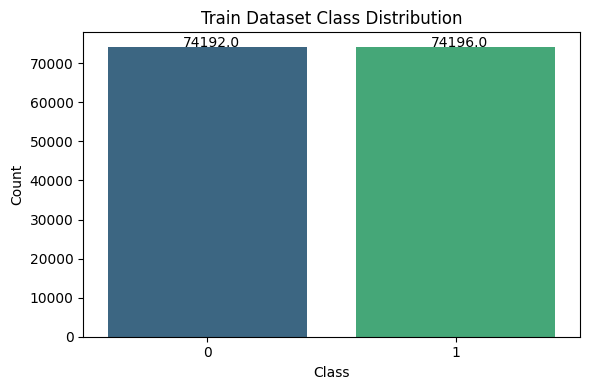

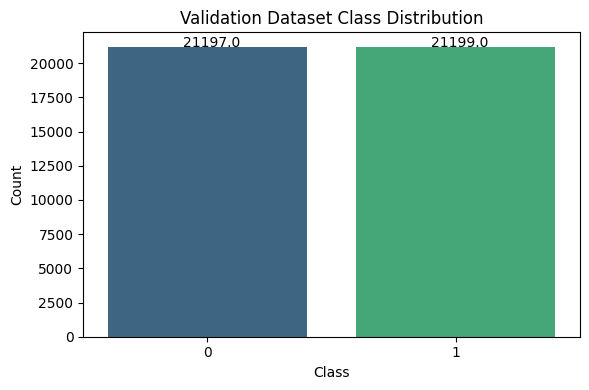

In [478]:
#Barplot for checking balanced / imbalaced classes
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(df, title, label_col='Label'):
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=df, x=label_col, palette='viridis')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 5))
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_df, "Train Dataset Class Distribution")
plot_class_distribution(val_df, "Validation Dataset Class Distribution")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


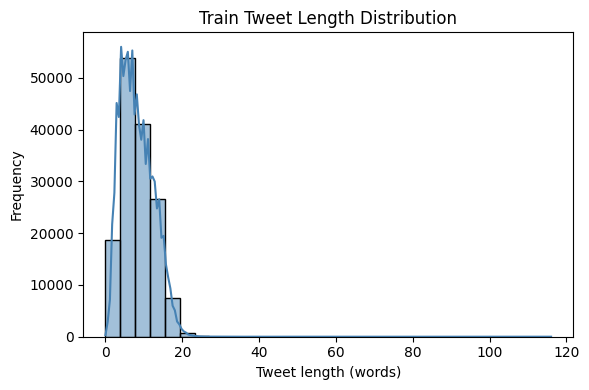

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


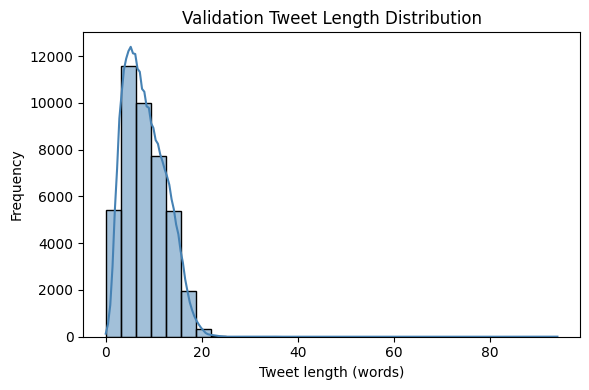

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


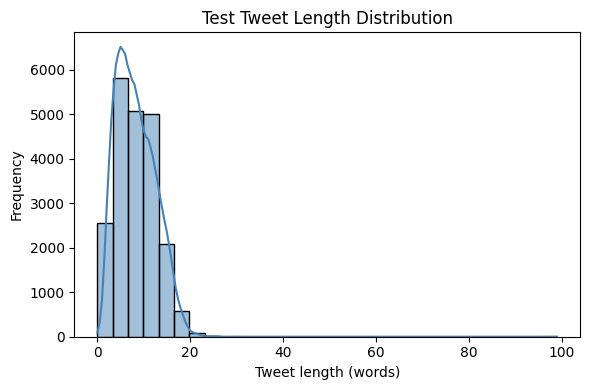

Train tweet length stats:
count    148388.000000
mean          8.252062
std           4.230418
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max         116.000000
Name: tweet_length, dtype: float64
Validation tweet length stats:
count    42396.000000
mean         8.264459
std          4.220340
min          0.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         94.000000
Name: tweet_length, dtype: float64
Very short tweets in train (≤2 words): 7717
Very long tweets in train (≥50 words): 8


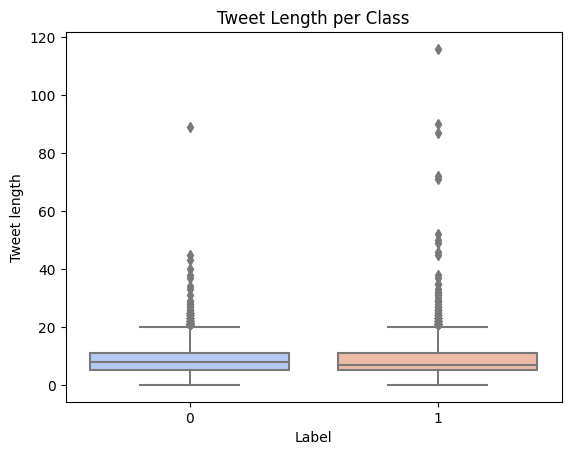

In [479]:
# Length of tweets
train_df['tweet_length'] = train_df['Text'].apply(lambda x: len(x.split()))
val_df['tweet_length'] = val_df['Text'].apply(lambda x: len(x.split()))
test_df['tweet_length'] = test_df['Text'].apply(lambda x: len(x.split()))

# Historigram

def plot_length_distribution(df, title):
    plt.figure(figsize=(6, 4))
    sns.histplot(df['tweet_length'], bins=30, kde=True, color='steelblue')
    plt.title(title)
    plt.xlabel("Tweet length (words)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_length_distribution(train_df, "Train Tweet Length Distribution")
plot_length_distribution(val_df, "Validation Tweet Length Distribution")
plot_length_distribution(test_df, "Test Tweet Length Distribution")

print("Train tweet length stats:")
print(train_df['tweet_length'].describe())

print("Validation tweet length stats:")
print(val_df['tweet_length'].describe())

print("Very short tweets in train (≤2 words):", (train_df['tweet_length'] <= 2).sum())
print("Very long tweets in train (≥50 words):", (train_df['tweet_length'] >= 50).sum())


#Boxplot
sns.boxplot(data=train_df, x='Label', y='tweet_length', palette='coolwarm')
plt.title("Tweet Length per Class")
plt.xlabel("Label")
plt.ylabel("Tweet length")
plt.show()

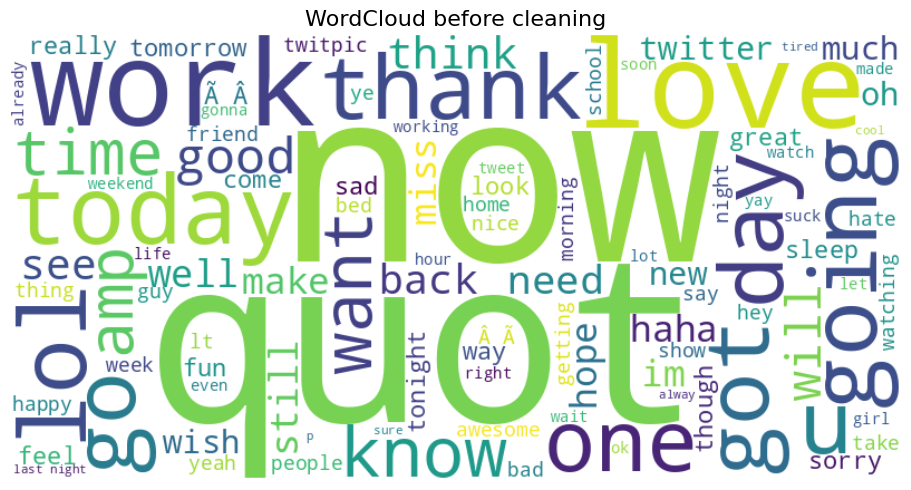

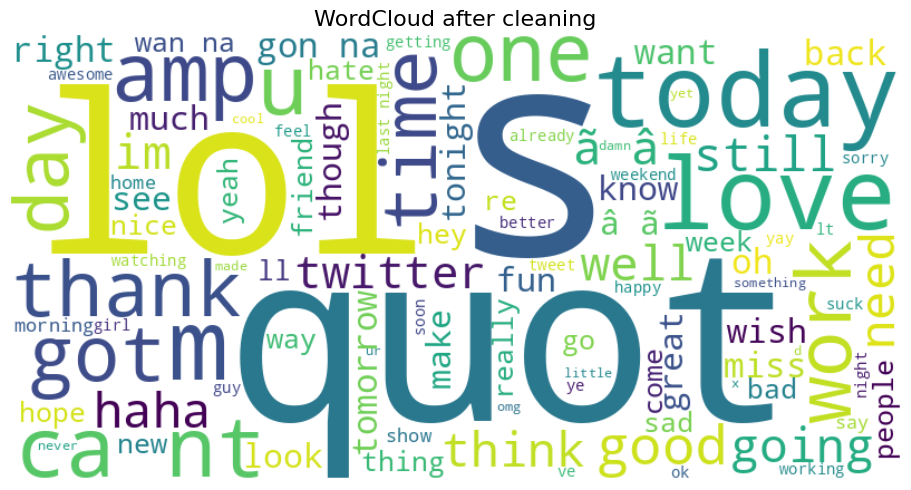

In [480]:
# Wordcloud before and after cleaning
!pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(text_series, title, max_words=100):
    text = " ".join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

train_df_raw = pd.read_csv("/kaggle/input/proj-dataset/train_dataset.csv")
generate_wordcloud(train_df_raw['Text'], "WordCloud before cleaning")
generate_wordcloud(train_df['Text'], "WordCloud after cleaning")



## Step 2: Deep representation with Embeddings
Below, we conduct an in-depth analysis of embeddings. Specifically, we experiment with two types of embeddings: GloVe & Word2Vec. Then, we experiment with two aggregation methods: mean pooling and max pooling. We check whether we achieve satisfactory results by omitting words or using a fixed UNK vector. Finally, we modify the embedding dimensions [50, 100, 300].

In [481]:
# word2vec
from gensim.models import KeyedVectors

model_path = '/kaggle/input/proj-dataset/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin'

print("Loading Word2Vec model...")
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print("Model loaded successfully!")

#checking 
print("Vector size:", w2v_model.vector_size)            
print("Words in vocab:", len(w2v_model.key_to_index))   
print(w2v_model['king'][:10])                            


Loading Word2Vec model...
Model loaded successfully!
Vector size: 300
Words in vocab: 3000000
[ 0.12597656  0.02978516  0.00860596  0.13964844 -0.02563477 -0.03613281
  0.11181641 -0.19824219  0.05126953  0.36328125]


In [482]:
# glove

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import os

print("Loading GloVe model...")

glove_path = "/kaggle/input/glove-data-3/glove.6B.300d.txt" #  50d, 300d etc
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

print("Loaded GloVe model successfully!")
print("Vector size:", glove_model.vector_size)

Loading GloVe model...
Loaded GloVe model successfully!
Vector size: 300


In [483]:
# aggregation functions : mean pooling & max pooling
import numpy as np

def generate_embedding_for_dataframe(df, model, embedding_dim, method='mean', unk_strategy='zero', model_name='w2v'):
    """
    Parameters:
    - df:  dataframe with column'Text'
    - model: pretrained GloVe ή Word2Vec model (KeyedVectors)
    - embedding_dim: embeddings dimensions
    - method: 'mean' ή 'max'
    - unk_strategy: 'zero' ή 'random'
    - model_name: 'w2v' ή 'glove'
    """
    all_vectors = []

    for text in df['Text']:
        tokens = text.split()  
        
        vectors = []
        for word in tokens:
            if word in model:
                vectors.append(model[word])
            else:
                if unk_strategy == 'random':
                    vectors.append(np.random.normal(scale=0.6, size=(embedding_dim,)))
                else:
                    vectors.append(np.zeros(embedding_dim))
        
        if not vectors:
            tweet_vec = np.zeros(embedding_dim)
        else:
            vectors = np.stack(vectors)
            if method == 'mean':
                tweet_vec = np.mean(vectors, axis=0)
            elif method == 'max':
                tweet_vec = np.max(vectors, axis=0)
            else:
                raise ValueError("Invalid aggregation method")

        all_vectors.append(tweet_vec)

    print(f"[{model_name.upper()}] Embeddings created: {len(all_vectors)} tweets × {embedding_dim} dims")
    return np.array(all_vectors)

# in word2vec 
train_embeddings_w2v = generate_embedding_for_dataframe(train_df, model=w2v_model, embedding_dim=300, method='mean', unk_strategy='zero', model_name='w2v')
val_embeddings_w2v   = generate_embedding_for_dataframe(val_df,   model=w2v_model, embedding_dim=300, method='mean', unk_strategy='zero', model_name='w2v')
test_embeddings_w2v  = generate_embedding_for_dataframe(test_df,  model=w2v_model, embedding_dim=300, method='mean', unk_strategy='zero', model_name='w2v')
# in glove
train_embeddings_glove = generate_embedding_for_dataframe(train_df, model=glove_model, embedding_dim=300, method='mean', unk_strategy='zero', model_name='glove')
val_embeddings_glove = generate_embedding_for_dataframe(val_df, model=glove_model, embedding_dim=300, method='mean', unk_strategy='zero', model_name='glove')
test_embeddings_glove = generate_embedding_for_dataframe(test_df, model=glove_model, embedding_dim=300, method='mean', unk_strategy='zero', model_name='glove')

[W2V] Embeddings created: 148388 tweets × 300 dims
[W2V] Embeddings created: 42396 tweets × 300 dims
[W2V] Embeddings created: 21199 tweets × 300 dims
[GLOVE] Embeddings created: 148388 tweets × 300 dims
[GLOVE] Embeddings created: 42396 tweets × 300 dims
[GLOVE] Embeddings created: 21199 tweets × 300 dims


## Dataset Preparation 

In [484]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np

#  dataset class
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels=None):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.embeddings[idx], self.labels[idx]
        else:
            return self.embeddings[idx]

#  Weighted sampler
def get_weighted_sampler(labels):
    class_counts = np.bincount(labels)
    weights = 1. / class_counts
    sample_weights = [weights[label] for label in labels]
    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#  DataLoader builder
def get_dataloaders(train_embeddings, train_labels,
                    val_embeddings, val_labels,
                    test_embeddings,
                    batch_size=64,
                    use_weighted_sampling=False):
    
    train_dataset = EmbeddingDataset(train_embeddings, train_labels)
    val_dataset   = EmbeddingDataset(val_embeddings, val_labels)
    test_dataset  = EmbeddingDataset(test_embeddings)

    if use_weighted_sampling:
        sampler = get_weighted_sampler(train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders(
    train_embeddings_w2v, train_df['Label'].values,
    val_embeddings_w2v, val_df['Label'].values,
    test_embeddings_w2v,
    batch_size=64,
    use_weighted_sampling=True  # (### TRYING FALSE ###)
)
train_loader_g, val_loader_g, test_loader_g = get_dataloaders(
    train_embeddings_glove, train_df['Label'].values,
    val_embeddings_glove, val_df['Label'].values,
    test_embeddings_glove,
    batch_size=64,
    use_weighted_sampling=True  # (### TRYING FALSE ###)
)

## Step 4 : Model 
Below, we implement our architecture. The baseline model follows the structure: Input(300) → Hidden Layer(128) → Dropout → ReLU → Output(2). In this phase, we conduct experiments with various configurations, including the number of layers, hidden units, activation functions, dropout rates, and BatchNorm, with all options explicitly detailed in the code. Subsequently, we explore different loss functions and optimizers (SGD, Adam, RMSprop), learning rates [0.1, 0.01, 0.001, 0.0001], weight decay values (0, 1e-5, 1e-4), and gradient clipping via clip_grad_norm.

In [485]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# Flexible Classifier , flexible for its options
class FlexibleClassifier(nn.Module):
    def __init__(self,
                 input_dim=300,
                 hidden_dims=[128],
                 output_dim=2,
                 activation='relu',
                 dropout_rate=0.5,
                 use_batchnorm=False):
        super(FlexibleClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'gelu':
                layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training + Evaluation
def train_model(model, train_loader, val_loader,
                optimizer_name='adam',
                lr=1e-3,
                loss_fn=None,
                num_epochs=10,
                clip_value=1.0,
                patience=3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Unsupported optimizer")

    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_probs, all_labels = [], [], []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_output = model(x_val)
                val_loss += loss_fn(val_output, y_val).item()

                probs = torch.softmax(val_output, dim=1)[:, 1]
                preds = torch.argmax(val_output, dim=1)

                all_probs.extend(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0 
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f" Early stopping triggered after {patience} epochs without improvement.")
                break

    # Plots
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid()
    plt.show()

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(" Loaded best model (lowest val loss).")





Epoch 1/9 | Train Loss: 0.5295 | Val Loss: 0.4961 | Acc: 0.7572 | F1: 0.7622 | AUC: 0.8400
Epoch 2/9 | Train Loss: 0.5066 | Val Loss: 0.4868 | Acc: 0.7617 | F1: 0.7654 | AUC: 0.8452
Epoch 3/9 | Train Loss: 0.4971 | Val Loss: 0.4827 | Acc: 0.7690 | F1: 0.7689 | AUC: 0.8491
Epoch 4/9 | Train Loss: 0.4928 | Val Loss: 0.4783 | Acc: 0.7691 | F1: 0.7721 | AUC: 0.8515
Epoch 5/9 | Train Loss: 0.4868 | Val Loss: 0.4765 | Acc: 0.7704 | F1: 0.7675 | AUC: 0.8526
Epoch 6/9 | Train Loss: 0.4808 | Val Loss: 0.4746 | Acc: 0.7734 | F1: 0.7710 | AUC: 0.8541
Epoch 7/9 | Train Loss: 0.4781 | Val Loss: 0.4775 | Acc: 0.7701 | F1: 0.7595 | AUC: 0.8539
Epoch 8/9 | Train Loss: 0.4738 | Val Loss: 0.4719 | Acc: 0.7736 | F1: 0.7765 | AUC: 0.8563
Epoch 9/9 | Train Loss: 0.4712 | Val Loss: 0.4718 | Acc: 0.7734 | F1: 0.7745 | AUC: 0.8558


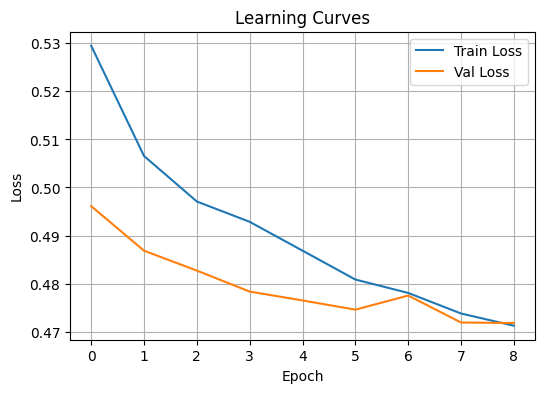

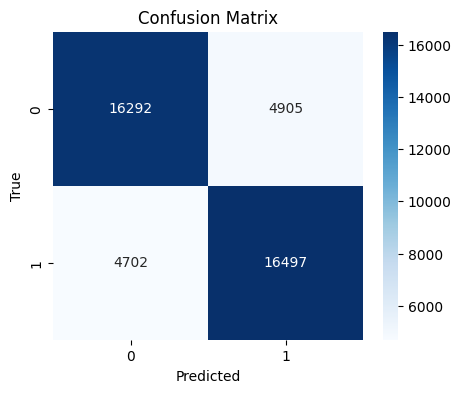

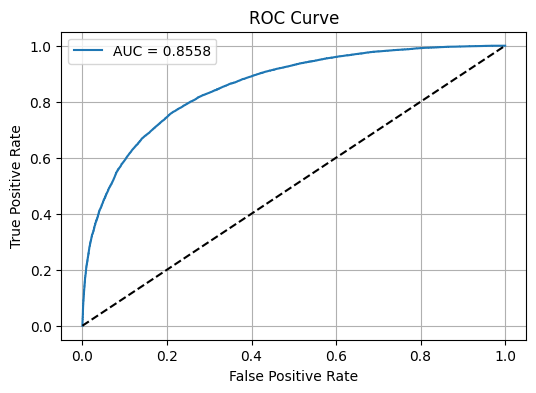

 Loaded best model (lowest val loss).
 test_embeddings_w2v.shape: 21199
 test_df.shape: (21199, 3)
 Missing 0 guesses from embedding.
 submission.csv created with shape: (21199, 2)


In [486]:
model = FlexibleClassifier(
    input_dim=300,
    hidden_dims=[300,150,75],
    output_dim=2,
    activation='gelu',
    dropout_rate=0.55,
    use_batchnorm=True 
)

train_model(
    model,
    train_loader, val_loader,
    optimizer_name='rmsprop',
    lr=0.0005,
    loss_fn=nn.CrossEntropyLoss(),
    num_epochs=9,
    clip_value=1.0,
    patience=3
)


#I had a porblem with the size of test . The result was not to remove the empty tweets
print(" test_embeddings_w2v.shape:", len(test_embeddings_w2v))
print(" test_df.shape:", test_df.shape)

#subsmission.csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_tensor = torch.tensor(test_embeddings_w2v, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(test_tensor)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()


missing = len(test_df) - len(preds)
print(f" Missing {missing} guesses from embedding.")

#  default  0
full_preds = np.concatenate([preds, np.zeros(missing, dtype=int)])

submission = pd.DataFrame({
    "ID": test_df["ID"],
    "Label": preds
})
submission.to_csv("submission.csv", index=False)
print(" submission.csv created with shape:", submission.shape)